# EP03 - Visão e processamento de imagens

Integrantes: 

- Bruna Lobato - 10666972
- Felipe Noronha - 10737032
- Izabela Fonsceca - 11583721

---

Você pode conferir as entregas anteriores e todas as imagens que constituem a base de dados no [GitHub do projeto](https://github.com/fcnoronha/visao-e-prcessamento-de-imagens).

## 0. Introdução

Esse Jupyter Notebook representa o exercicio programa 3, que consiste em realizar a **segmentação das imagens dos objetos** e **classificação dos objetos utilizando aprendizado de maquina**.

In [56]:
import os
import random
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

from skimage import io
from skimage.filters import threshold_sauvola
from skimage.metrics import adapted_rand_error
from skimage.morphology import remove_small_objects
from skimage.util import img_as_ubyte, img_as_float, img_as_int

from scipy.ndimage import binary_fill_holes
from cv2 import boundingRect, rectangle

# caminhos para os datasets
RAW_PATH = 'datasets/raw/'
GREY_PATH = 'datasets/original-gray/'
NORM_PATH = 'datasets/normalized/'
AUG_PATH = 'datasets/augmented/'
MANUAL_SEGMENTED_PATH = 'datasets/segmented/manual/'
AUTOM_SEGMENTED_PATH = 'datasets/segmented/automated/'
MANUAL_FERET_PATH = 'datasets/feret_box/manual/'
AUTOM_FERET_PATH = 'datasets/feret_box/automated/'

# Parte 1. Segmentação e Feret Box

A segmentação consiste em demarcar o objeto de interesse na imagem. Em particular, criamos uma imagem binaria onde os pixels com valor 1 cobrem o objeto e os com valor 0 cobrem o fundo. Utilizamos dois metodos para geração das imagens segmentadas:

- Manual, onde utilizamos um editor de imagens para geração de segmentações que oferecessem um _ground-truth_, e
- Automática, utilizando funções da biblioteca `skimage` para tornar a classificação de todas as imagens do dataset algo factivel.

Além disso, nessa parte, vamos gerar as _Feret Boxes_ das imagens segmentadas, tanto manualmente quanto automaticamente.

## 1.1 Segmentação manual

Para realizar a segmentação manual, selecionamos 175 imagens aleatorias da nossa base de dados original, o que representa 15% das imagens. Em seguida, usamos o software de edição de imagens GIMP para criar as segmentações. As imagens dessa parte ficam em `datasets/segmented/manual`.

Uma pequena amostra das imagens segmentadas é apresentada a seguir.

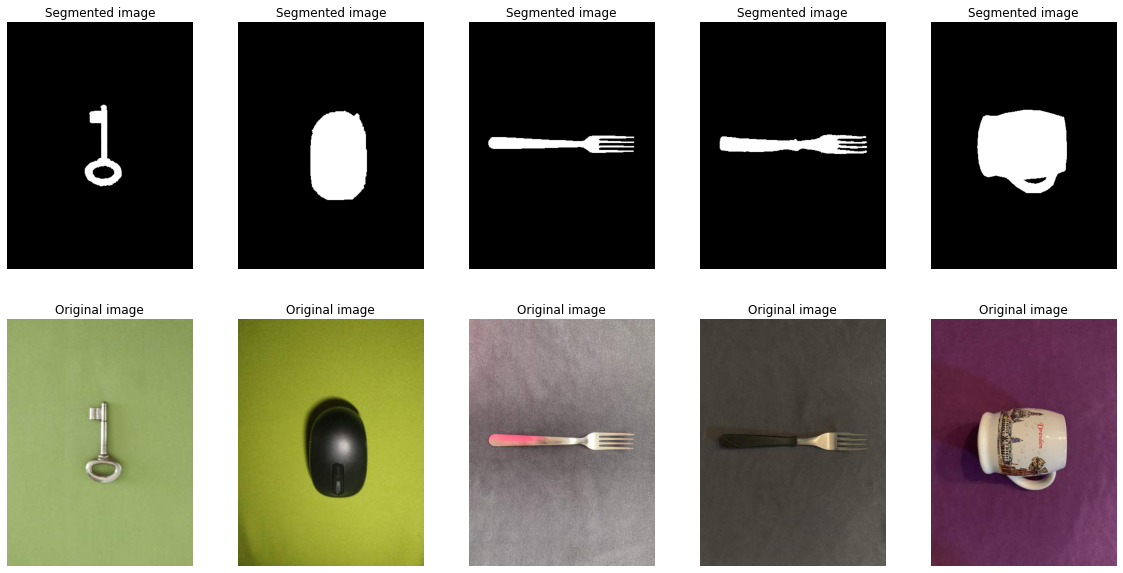

In [60]:
n_samples = 5
image_names = os.listdir(MANUAL_SEGMENTED_PATH)
selection = np.random.choice(image_names, n_samples)

fig, ax = plt.subplots(2, n_samples, figsize = (20, 10))
for i, img_name in zip(range(6), selection):
    
    segmented_image = io.imread(MANUAL_SEGMENTED_PATH + img_name)
    ax[0, i%n_samples].imshow(segmented_image, cmap='gray')
    ax[0, i%n_samples].axis('off')
    ax[0, i%n_samples].set_title('Segmented image')

    original_image = io.imread(RAW_PATH + img_name[:-3] + 'jpg')
    ax[1, i%n_samples].imshow(original_image, cmap='gray')
    ax[1, i%n_samples].axis('off')
    ax[1, i%n_samples].set_title('Original image')

plt.show()

## 1.2 Segmentação automatica

Para lidar com as mais de mil imagens originais, vamos utilizar metodos da biblioteca `skimage` para realizarmos a segmentação automatica utilizando o metodo [`threshold_sauvola`](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_sauvola). Além disso, vamos usar o metodo [`binary_fill_holes`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.morphology.binary_fill_holes.html) do _ndimage_ para preencher buracos na segmentação junto com o [`remove_small_objects`](https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects) para remover pontinhos da imagem.

As imagens dessa parte ficam em `datasets/segmented/automated`.


In [38]:
def segment_image(image):
    
    threshold = threshold_sauvola(image, window_size=35)
    mask = image > threshold

    # invert if the object (smaller part) is not white
    n_black = np.count_nonzero(mask == False)
    n_white = np.count_nonzero(mask == True)
    if (n_white > n_black):
        mask = np.bitwise_not(mask)

    mask_without_points = remove_small_objects(mask > 0, 64)
    segmentation_filled = binary_fill_holes(mask_without_points)

    return segmentation_filled

for file in os.listdir(GREY_PATH):
        
    image_name = file.split('.')[0]
    image = io.imread(GREY_PATH + file, as_gray=True)
    segmentation = segment_image(image)

    io.imsave(AUTOM_SEGMENTED_PATH + image_name + '.png', img_as_ubyte(segmentation), check_contrast=False)

Abaixo, podemos ver alguns exemplos das imagens segmentadas automaticamente.

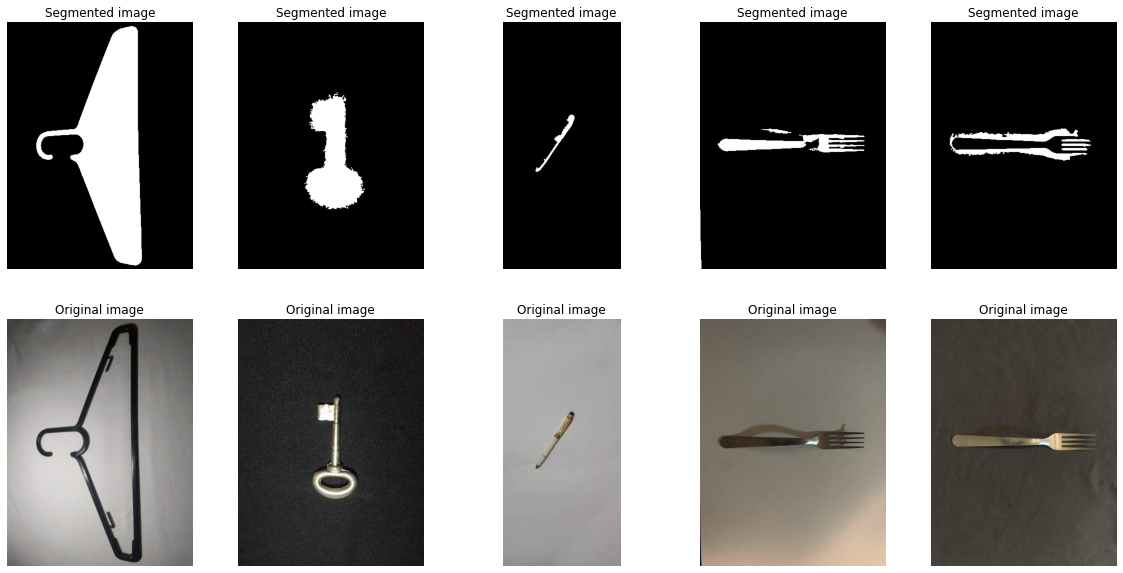

In [61]:
n_samples = 5
image_names = os.listdir(AUTOM_SEGMENTED_PATH)
selection = np.random.choice(image_names, n_samples)

fig, ax = plt.subplots(2, n_samples, figsize = (20, 10))
for i, img_name in zip(range(6), selection):
    
    segmented_image = io.imread(AUTOM_SEGMENTED_PATH + img_name)
    ax[0, i%n_samples].imshow(segmented_image, cmap='gray')
    ax[0, i%n_samples].axis('off')
    ax[0, i%n_samples].set_title('Segmented image')

    original_image = io.imread(RAW_PATH + img_name[:-3] + 'jpg')
    ax[1, i%n_samples].imshow(original_image, cmap='gray')
    ax[1, i%n_samples].axis('off')
    ax[1, i%n_samples].set_title('Original image')

plt.show()

## 1.3 Feret box

Abaixo, usamos metodos da biblioteca _cv2_ para calcular as _feret boxes_ das segmentações.

In [65]:
def generate_feret_box(image):

    x_right, y_up, width, heigth = boundingRect(image)
    feret_box = rectangle(image, (x_right, y_up), (x_right+width, y_up+heigth), 255, -1)
    return feret_box

for file in os.listdir(AUTOM_SEGMENTED_PATH):
        
    image = io.imread(AUTOM_SEGMENTED_PATH + file, as_gray=True)
    feret_box = generate_feret_box(image.astype(np.uint8))

    io.imsave(AUTOM_FERET_PATH + file, img_as_ubyte(feret_box), check_contrast=False)

for file in os.listdir(MANUAL_SEGMENTED_PATH):
        
    image = io.imread(MANUAL_SEGMENTED_PATH + file, as_gray=True)
    feret_box = generate_feret_box(image.astype(np.uint8))

    io.imsave(MANUAL_FERET_PATH + file, img_as_ubyte(feret_box), check_contrast=False)

Abaixo, podemos ver algumas _feret boxes_ geradas a partir das imagens segmentadas manualmente.

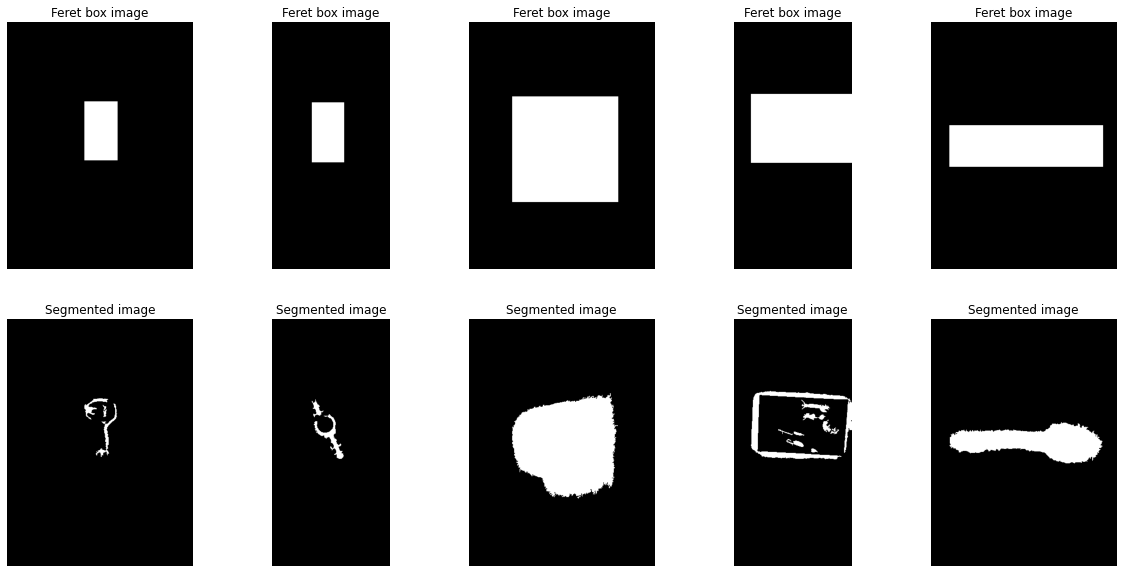

In [66]:
n_samples = 5
image_names = os.listdir(AUTOM_SEGMENTED_PATH)
selection = np.random.choice(image_names, n_samples)

fig, ax = plt.subplots(2, n_samples, figsize = (20, 10))
for i, img_name in zip(range(6), selection):
    
    segmented_image = io.imread(AUTOM_FERET_PATH + img_name)
    ax[0, i%n_samples].imshow(segmented_image, cmap='gray')
    ax[0, i%n_samples].axis('off')
    ax[0, i%n_samples].set_title('Feret box image')

    original_image = io.imread(AUTOM_SEGMENTED_PATH + img_name)
    ax[1, i%n_samples].imshow(original_image, cmap='gray')
    ax[1, i%n_samples].axis('off')
    ax[1, i%n_samples].set_title('Segmented image')

plt.show()

# Parte 2. Extração de features, PCA e classificação



# Parte 3. Metricas e relatorio




Para encontrar os melhores parametros, fizemos uma busca com a intenção de minimizar o [`adapted_rand_error`](https://scikit-image.org/docs/dev/api/skimage.metrics.html#skimage.metrics.adapted_rand_error) que compara a imagem _ground truth_ com a segmentação. Usamos esses parametros para segmentar todas as imagens.

Mais informações sobre as tecnicas aqui usadas podem ser encontradas [neste tutorial](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_metrics.html).

In [32]:


def calculate_error_from_parameters(sigma, low_t, high_t, min_size):
    
    error_list = []
    for file in os.listdir(MANUAL_SEGMENTED_PATH):

        if (os.path.isdir(MANUAL_SEGMENTED_PATH + file)): continue

        ground_truth_image = img_as_int(io.imread(MANUAL_SEGMENTED_PATH + file, as_gray=True))
        image = io.imread(GREY_PATH + file[:-3] + 'jpg')
        segmentation = segment_image(image, sigma, low_t, high_t, min_size)

        error, precision, recall = adapted_rand_error(ground_truth_image, segmentation)
        error_list.append(error)
    
    return np.mean(error_list)